In [1]:
# Cell 1 — Setup: mount Drive + install packages (run once)
from google.colab import drive
drive.mount('/content/drive')

# Install libs (Colab). If already installed, these will be quick.
!pip install -q xgboost catboost sentence-transformers optuna textstat emoji imbalanced-learn


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 102.7 MB/s eta 0:00:00


In [2]:
# Cell 2 — Imports and global config
import os, json, joblib, re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.utils.class_weight import compute_class_weight
from scipy import sparse

import xgboost as xgb
from catboost import CatBoostClassifier

from sentence_transformers import SentenceTransformer
import optuna
import textstat
import emoji

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



In [3]:
# Cell 3 — Load data (update path if needed)
DATA_PATH = "/content/drive/MyDrive/Facebook_data_txt.csv"  # <- change if different
df = pd.read_csv(DATA_PATH)
df = df.copy()
print("Loaded data shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Loaded data shape: (5000, 11)
Columns: ['post_id', 'timestamp', 'text', 'category', 'sentiment', 'language', 'has_link', 'likes', 'comments', 'shares', 'is_spam']


,post_id,timestamp,text,category,sentiment,language,has_link,likes,comments,shares,is_spam
0,1502,2024-11-25 10:10:00,Mental health matters. Take a break. 🎉,health_wellness,negative,hi,0,4,1,0,0
1,2587,2025-03-28 14:41:00,Having trouble logging into my Stark account—a...,customer_support,neutral,en,0,8,0,2,0
2,2654,2025-05-20 02:31:00,When you open the fridge and forget why you ca...,meme_joke,positive,en,0,74,18,4,0


In [4]:
# Cell 4 — Feature engineering: engagement target + text/time features
# Make sure columns likes/comments/shares/timestamp/text exist
df["likes"] = df.get("likes", 0).fillna(0).astype(float)
df["comments"] = df.get("comments", 0).fillna(0).astype(float)
df["shares"] = df.get("shares", 0).fillna(0).astype(float)

# Engagement and binary target (top 30% => High)
df["engagement"] = df["likes"] + df["comments"] + df["shares"]
threshold = df["engagement"].quantile(0.70)
df["target"] = (df["engagement"] >= threshold).astype(int)
print("Target distribution:\n", df["target"].value_counts())

# Text features
df["text"] = df["text"].astype(str).fillna("")
df["char_count"] = df["text"].apply(len)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
df["avg_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split())>0 else 0.0)
df["emoji_count"] = df["text"].apply(lambda x: emoji.emoji_count(x))
df["has_hashtag"] = df["text"].apply(lambda x: 1 if "#" in x else 0)
df["fk_grade"] = df["text"].apply(lambda x: textstat.flesch_kincaid_grade(x) if len(x.split())>0 else 0.0)

# Time features — ensure timestamp column exists or set to now
if "timestamp" not in df.columns:
    df["timestamp"] = pd.Timestamp.now()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce").fillna(pd.Timestamp.now())
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["dow"].isin([5,6]).astype(int)

# Cyclical encodings
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)

print("Features created, sample:")
df[num_cols[:6]] if 'num_cols' in globals() else print(df[["char_count","word_count","emoji_count"]].head())


Target distribution:
 target
0    3485
1    1515
Name: count, dtype: int64
Features created, sample:
   char_count  word_count  emoji_count
0          38           7            1
1          53           8            0
2          62          12            1
3          47           8            0
4          33           6            0


In [5]:
# Cell 5 — Embedding + OHE + Scaler -> create X, y
EMBED_MODEL = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMBED_MODEL)

# Text embeddings (convert_to_numpy used for speed)
X_text_emb = embedder.encode(df["text"].tolist(), show_progress_bar=True, convert_to_numpy=True)
X_text_emb = sparse.csr_matrix(X_text_emb)  # convert to sparse

# Categorical columns used in your original code
cat_cols = ["category", "language"]
# make OHE robust to sklearn versions (sparse_output param compatibility)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

if set(cat_cols).issubset(df.columns):
    X_cat = ohe.fit_transform(df[cat_cols])
else:
    X_cat = sparse.csr_matrix((len(df), 0))

# Numeric columns in same order as original
num_cols = ["char_count","word_count","avg_word_len","emoji_count","has_hashtag","fk_grade",
            "hour","dow","is_weekend","hour_sin","hour_cos","dow_sin","dow_cos"]
scaler = StandardScaler(with_mean=False)
X_num = scaler.fit_transform(df[num_cols])
X_num = sparse.csr_matrix(X_num)  # convert to sparse for hstack

# Combine all features (sparse CSR)
X = sparse.hstack([X_text_emb, X_cat, X_num], format="csr")
y = df["target"].values

print("Final feature matrix shape:", X.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Final feature matrix shape: (5000, 412)


In [6]:
# Cell 6 — Train/Test split and class_weights
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)

# Use original variable names for downstream compatibility
X_train_res, y_train_res = X_train, y_train


Class weights: {np.int64(0): np.float64(0.7173601147776184), np.int64(1): np.float64(1.6501650165016502)}


In [7]:
# Cell 7 — Define base models (same config as your original)
# Logistic Regression
logreg_model = LogisticRegression(max_iter=500, class_weight="balanced", solver="saga", random_state=RANDOM_STATE)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE)

# XGBoost base (will be tuned by Optuna later)
scale_pos = np.bincount(y_train)[0] / (np.bincount(y_train)[1] if np.bincount(y_train)[1]>0 else 1)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False,
                              n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8,
                              colsample_bytree=0.8, scale_pos_weight=scale_pos, random_state=RANDOM_STATE)

# CatBoost
cat_model = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, class_weights=[1, scale_pos], verbose=0, random_state=RANDOM_STATE)

models = {"LogReg": logreg_model, "RandomForest": rf_model, "XGBoost": xgb_model, "CatBoost": cat_model}



=== LogReg ===
Accuracy: 0.7510 | F1: 0.6566 | Precision: 0.5640 | Recall: 0.7855
              precision    recall  f1-score   support

    Not-High       0.89      0.74      0.80       697
        High       0.56      0.79      0.66       303

    accuracy                           0.75      1000
   macro avg       0.73      0.76      0.73      1000
weighted avg       0.79      0.75      0.76      1000



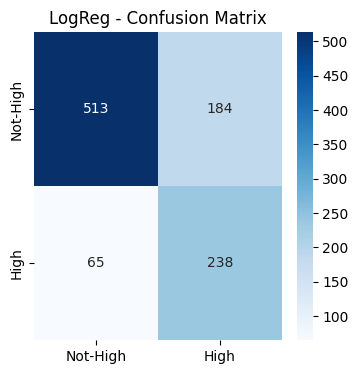


=== RandomForest ===
Accuracy: 0.7260 | F1: 0.5651 | Precision: 0.5443 | Recall: 0.5875
              precision    recall  f1-score   support

    Not-High       0.81      0.79      0.80       697
        High       0.54      0.59      0.57       303

    accuracy                           0.73      1000
   macro avg       0.68      0.69      0.68      1000
weighted avg       0.73      0.73      0.73      1000



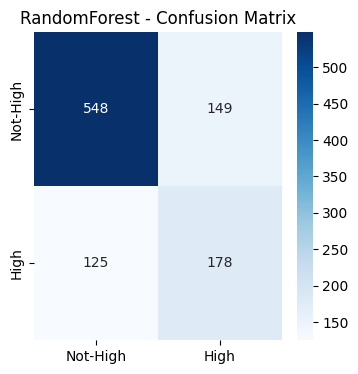


=== XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:55:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7180 | F1: 0.5538 | Precision: 0.5319 | Recall: 0.5776
              precision    recall  f1-score   support

    Not-High       0.81      0.78      0.79       697
        High       0.53      0.58      0.55       303

    accuracy                           0.72      1000
   macro avg       0.67      0.68      0.67      1000
weighted avg       0.73      0.72      0.72      1000



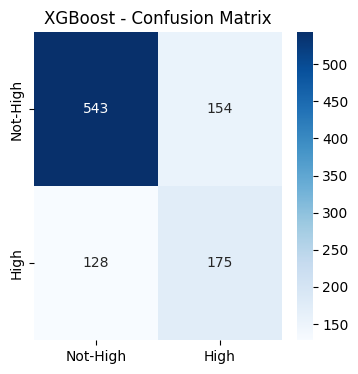


=== CatBoost ===
Accuracy: 0.7290 | F1: 0.5888 | Precision: 0.5449 | Recall: 0.6403
              precision    recall  f1-score   support

    Not-High       0.83      0.77      0.80       697
        High       0.54      0.64      0.59       303

    accuracy                           0.73      1000
   macro avg       0.69      0.70      0.69      1000
weighted avg       0.74      0.73      0.73      1000



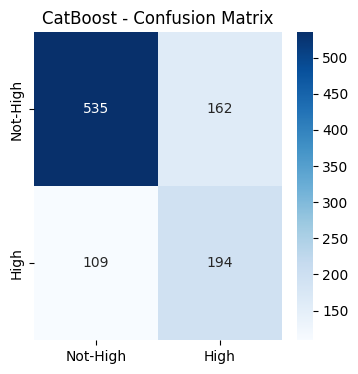

In [8]:
# Cell 8 — Evaluation helper & run base model evaluations
def evaluate(model, X_tr, y_tr, X_te, y_te, name, threshold=0.5):
    print(f"\n=== {name} ===")
    model.fit(X_tr, y_tr)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:,1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average="binary")
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")
    print(classification_report(y_te, y_pred, target_names=["Not-High", "High"]))

    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not-High","High"], yticklabels=["Not-High","High"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Evaluate base models (this will fit each model)
for name, model in models.items():
    evaluate(model, X_train_res, y_train_res, X_test, y_test, name)



=== VotingClassifier (initial) ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:56:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7250 | F1: 0.5877 | Precision: 0.5385 | Recall: 0.6469
              precision    recall  f1-score   support

    Not-High       0.83      0.76      0.79       697
        High       0.54      0.65      0.59       303

    accuracy                           0.72      1000
   macro avg       0.69      0.70      0.69      1000
weighted avg       0.74      0.72      0.73      1000



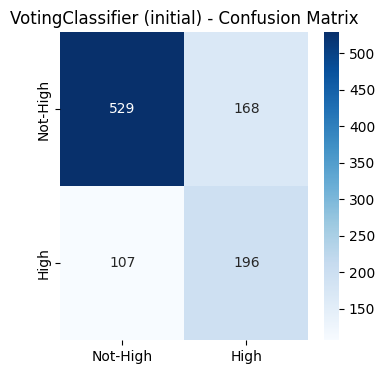


=== StackingClassifier ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:57:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:59:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:59:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:59:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:00:05] WARNING: /w

Accuracy: 0.7510 | F1: 0.6556 | Precision: 0.5643 | Recall: 0.7822
              precision    recall  f1-score   support

    Not-High       0.89      0.74      0.81       697
        High       0.56      0.78      0.66       303

    accuracy                           0.75      1000
   macro avg       0.73      0.76      0.73      1000
weighted avg       0.79      0.75      0.76      1000



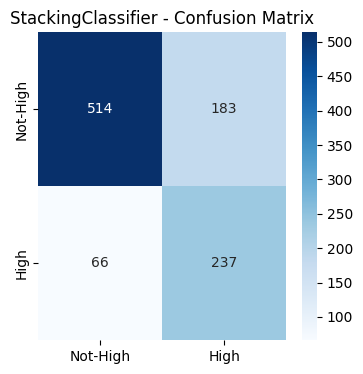

In [9]:
# Cell 9 — Voting and Stacking ensembles (train & evaluate)
voting_clf = VotingClassifier(estimators=[("xgb", xgb_model), ("cat", cat_model), ("logreg", logreg_model)], voting="soft")
evaluate(voting_clf, X_train_res, y_train_res, X_test, y_test, "VotingClassifier (initial)")

stacking_clf = StackingClassifier(estimators=[("xgb", xgb_model), ("cat", cat_model), ("rf", rf_model)],
                                  final_estimator=LogisticRegression(max_iter=500, class_weight="balanced"),
                                  passthrough=True, n_jobs=1)
evaluate(stacking_clf, X_train_res, y_train_res, X_test, y_test, "StackingClassifier")


In [10]:
# Cell 10 — Optuna tuning (XGBoost) — optimize XGB hyperparams using holdout
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "n_estimators": trial.suggest_int("n_estimators", 200, 500),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "scale_pos_weight": scale_pos,
        "random_state": RANDOM_STATE
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds, average="binary")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("Optuna best params:", study.best_trial.params)


[I 2025-10-22 13:04:52,669] A new study created in memory with name: no-name-172fbc72-e766-443e-bce1-9a524248a578
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:04:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-10-22 13:05:22,957] Trial 0 finished with value: 0.5406301824212272 and parameters: {'n_estimators': 222, 'max_depth': 9, 'learning_rate': 0.16135581780215416, 'subsample': 0.8024878869842786, 'colsample_bytree': 0.6577333141197833}. Best is trial 0 with value: 0.5406301824212272.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:05:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-10-22 13:05:34,862] Trial 1 finished with value: 0.5727272727272728 and parameters: {'n_estimators': 451, 'max_depth': 4, 'learning_rate':

Optuna best params: {'n_estimators': 251, 'max_depth': 8, 'learning_rate': 0.011911968944582399, 'subsample': 0.9435406727370805, 'colsample_bytree': 0.6444898414526268}


In [11]:
..............000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000# Cell 11 — Build final models using best Optuna params, then find best threshold
best_xgb = xgb.XGBClassifier(**study.best_trial.params, use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE)
best_cat = CatBoostClassifier(iterations=400, depth=6, learning_rate=0.1, class_weights=[1, scale_pos], verbose=0, random_state=RANDOM_STATE)
best_logreg = LogisticRegression(max_iter=500, C=1.0, class_weight="balanced", solver="saga", random_state=RANDOM_STATE)

voting_clf = VotingClassifier(estimators=[("XGB", best_xgb), ("CatBoost", best_cat), ("LogReg", best_logreg)], voting="soft")
voting_clf.fit(X_train, y_train)

# Find best threshold on test using F1
y_proba = voting_clf.predict_proba(X_test)[:,1]
best_thresh, best_f1 = 0.5, 0
for thresh in np.arange(0.3, 0.7, 0.01):
    y_pred = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred, average="binary")
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh
print("Best Threshold:", best_thresh, "Best F1:", best_f1)


SyntaxError: invalid syntax (ipython-input-4163795162.py, line 1)

In [ ]:
# Cell 12 — Final evaluation with best threshold
evaluate(voting_clf, X_train, y_train, X_test, y_test, "Voting Classifier (Optuna + Threshold)", threshold=best_thresh)

# Optional: Plot XGBoost logloss curve for the tuned XGB if you want (train it with eval_set to view history)
best_xgb_loss = xgb.XGBClassifier(**study.best_trial.params, use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE)
best_xgb_loss.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
results = best_xgb_loss.evals_result()
if 'validation_0' in results and 'logloss' in results['validation_0']:
    epochs = len(results['validation_0']['logloss'])
    plt.figure(figsize=(8,5))
    plt.plot(range(epochs), results['validation_0']['logloss'], label='Train')
    plt.plot(range(epochs), results['validation_1']['logloss'], label='Valid')
    plt.xlabel("Boosting rounds")
    plt.ylabel("Logloss")
    plt.legend()
    plt.title("XGBoost Log Loss (Optuna-tuned)")
    plt.show()


In [ ]:
# Cell 13 — Save artifacts for Streamlit / inference
os.makedirs("artifacts", exist_ok=True)
joblib.dump(voting_clf, "artifacts/reach_voting.joblib")
joblib.dump(ohe, "artifacts/reach_ohe.joblib")
joblib.dump(scaler, "artifacts/reach_scaler.joblib")
joblib.dump({"best_thresh": float(best_thresh)}, "artifacts/reach_thresh.joblib")

meta = {"embedder": EMBED_MODEL, "cat_cols": cat_cols, "num_cols": num_cols}
with open("artifacts/reach_meta.json", "w") as f:
    json.dump(meta, f)

print("Saved artifacts to ./artifacts/")
!ls -lah artifacts


In [ ]:
# Cell 14 — Inference helper (single-caption inference)
# This function uses the in-memory variables (embedder, ohe, scaler, voting_clf, best_thresh)
def prepare_reach_input(caption, time=None, category=None, language=None):
    import textstat, emoji
    # defaults
    if time is None or time == "":
        time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if category is None:
        category = ""
    if language is None:
        language = ""

    # create single-row DF with required cat columns if needed
    row = {"text": caption, "timestamp": time}
    # ensure cat_cols present
    for c in cat_cols:
        row[c] = category if c == "category" else (language if c == "language" else "")

    df_row = pd.DataFrame([row])

    # compute numeric features exactly like training
    df_row["char_count"] = df_row["text"].apply(len)
    df_row["word_count"] = df_row["text"].apply(lambda x: len(x.split()))
    df_row["avg_word_len"] = df_row["text"].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split())>0 else 0.0)
    df_row["emoji_count"] = df_row["text"].apply(lambda x: emoji.emoji_count(x))
    df_row["has_hashtag"] = df_row["text"].apply(lambda x: 1 if "#" in x else 0)
    df_row["fk_grade"] = df_row["text"].apply(lambda x: textstat.flesch_kincaid_grade(x) if len(x.split())>0 else 0.0)

    df_row["timestamp"] = pd.to_datetime(df_row["timestamp"], errors="coerce").fillna(pd.Timestamp.now())
    df_row["hour"] = df_row["timestamp"].dt.hour
    df_row["dow"] = df_row["timestamp"].dt.dayofweek
    df_row["is_weekend"] = df_row["dow"].isin([5,6]).astype(int)
    df_row["hour_sin"] = np.sin(2*np.pi*df_row["hour"]/24)
    df_row["hour_cos"] = np.cos(2*np.pi*df_row["hour"]/24)
    df_row["dow_sin"]  = np.sin(2*np.pi*df_row["dow"]/7)
    df_row["dow_cos"]  = np.cos(2*np.pi*df_row["dow"]/7)

    # embeddings
    X_text = embedder.encode(df_row["text"].tolist(), convert_to_numpy=True)  # shape (1, emb_dim)

    # categorical
    if X_cat.shape[1] == 0:
        X_cat_row = sparse.csr_matrix((1, 0))
    else:
        X_cat_row = ohe.transform(df_row[cat_cols])

    # numeric scaled (use fitted scaler)
    X_num_row = scaler.transform(df_row[num_cols])
    # combine — convert everything to dense for a single-row prediction (safe)
    X_final = np.hstack([X_text, X_cat_row.toarray(), X_num_row])

    # predict
    if hasattr(voting_clf, "predict_proba"):
        prob = float(voting_clf.predict_proba(X_final)[:,1][0])
    else:
        prob = float(voting_clf.predict(X_final)[0])
    label = "High Reach" if prob >= best_thresh else "Low Reach"

    return {"reach_probability": prob, "predicted_label": label}

# Quick test
sample_caption = "Exciting new update launched today! Check it out 🚀"
print("Sample inference:", prepare_reach_input(sample_caption))


In [ ]:
# =====================================================
# 📊 Visualization and Summary for Reach Prediction Dataset
# =====================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Plot styling
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 11

# ✅ Figure 2: Sample posts
print("Figure 2: Sample posts from Reach Dataset (D1)")
display(df[['text', 'likes', 'comments', 'shares', 'target']].head(5))

# =====================================================
# 🔹 Table 1: Class Distribution
# =====================================================

reach_counts = df['target'].value_counts().sort_index()
reach_percent = (reach_counts / reach_counts.sum()) * 100

reach_dist = pd.DataFrame({
    'Class': ['Low Reach (0)', 'High Reach (1)'],
    'Count': reach_counts.values,
    'Percent': reach_percent.round(2).values
})

print("\nTable 1: Reach Class Distribution")
display(reach_dist)

# ✅ Bar plot of Reach Class Distribution
sns.barplot(x=['Low Reach (0)', 'High Reach (1)'], y=reach_counts.values, palette="pastel")
plt.title("Reach Class Distribution")
plt.xlabel("Reach Label")
plt.ylabel("Count")
plt.show()

# =====================================================
# 🔹 Table 2: Train/Test Split Summary
# =====================================================

# Recreate same split for clarity (if X_train/X_test not available in memory)
if 'X_train' not in locals():
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

# ✅ FIX: use .shape[0] for sparse matrices instead of len()
table2 = pd.DataFrame({
    'Split': ['Train', 'Test'],
    'Samples': [X_train.shape[0], X_test.shape[0]]
})

print("\nTable 2: Reach Dataset Split Summary")
display(table2)

# ✅ Pie Chart for split sizes
plt.pie(
    [X_train.shape[0], X_test.shape[0]],
    labels=['Train', 'Test'],
    autopct='%1.1f%%',
    colors=sns.color_palette("pastel")
)
plt.title("Reach Dataset Split Distribution")
plt.show()
